In [1]:
from collections import OrderedDict
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import os
import yaml
import pandas as pd
import torch
import shap
from evaluate import get_trained_model
from utils import *
from dateset import load_full_features
import matplotlib.pyplot as plt

In [2]:
disease = "EW-T2D"
model = "MTMFTransformer"
feature = "ko,species"
seed = 472

In [3]:
# 加载模型参数
config_path = f"Config/{disease}.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    modelconfig = config[model][feature]

# 加载数据
setup_seed(seed)
feature = feature.split(",")

# Load feature
x_train, x_test, y_train, y_test = load_full_features(seed=seed, disease=disease, feature=feature)
inputs_dim = OrderedDict({"f1_input": x_train['f1_input'].shape,
                          "f2_input": x_train['f2_input'].shape})  # Dict, shape of each input


['ko', 'species']
['ERR260139', 'ERR260140', 'ERR260144', 'ERR260147', 'ERR260149']
['ERR260139', 'ERR260140', 'ERR260144', 'ERR260147', 'ERR260149']
Load dataset from /hdd/wmh/MSFT-Transfromer/Data/EW-T2D/ko_abundance.csv
Load dataset from /hdd/wmh/MSFT-Transfromer/Data/EW-T2D/species_abundance.csv
Counter({1: 42, 0: 34}) Counter({1: 11, 0: 9})


In [4]:
# 拼接输入
x_train = np.concatenate(list(x_train.values()), axis=1).astype(np.float32)
x_test = np.concatenate(list(x_test.values()), axis=1).astype(np.float32)
x_train = torch.Tensor(x_train).to("cuda")
x_test = torch.Tensor(x_test).to("cuda")
x_combined = torch.cat((x_train, x_test), dim=0)  # dim=0 表示在 batch 维度上拼接

In [5]:
ko_feat = list(pd.read_csv("./Data/EW-T2D/ko_abundance.csv").columns)[2:]
species_feat = list(pd.read_csv("./Data/EW-T2D/species_abundance.csv").columns)[2:]
feat_names = ko_feat + species_feat

In [6]:
# 去除过长featname
feat_names = [x if len(x) < 20 else x[x.rfind('|')+1:] for x in feat_names]

In [7]:
modelconfig['inputs_dim'] = inputs_dim
modelconfig['use_bottleneck'] = True
modelconfig['btn_init'] = "embed"
modelconfig['use_cross_atn'] = True

record = OrderedDict(modelconfig)
record.pop('inputs_dim')

record['seed'] = seed
record['mode'] = 0
record['feature'] = ','.join(feature)

logdir = f"./results/{disease}"
if not os.path.exists(logdir):
    os.makedirs(logdir)

logpath = f"{logdir}/{model}_evaluate.csv"

In [8]:
net = get_trained_model(disease=disease, seed=seed, modelconfig=modelconfig, explainable=True)

In [9]:
x_test.shape

torch.Size([20, 1584])

In [10]:
# shap.initjs()

In [5]:
explainer = shap.DeepExplainer(net.module_, x_test)
shap_values = explainer.shap_values(x_test, check_additivity=False)

NameError: name 'shap' is not defined

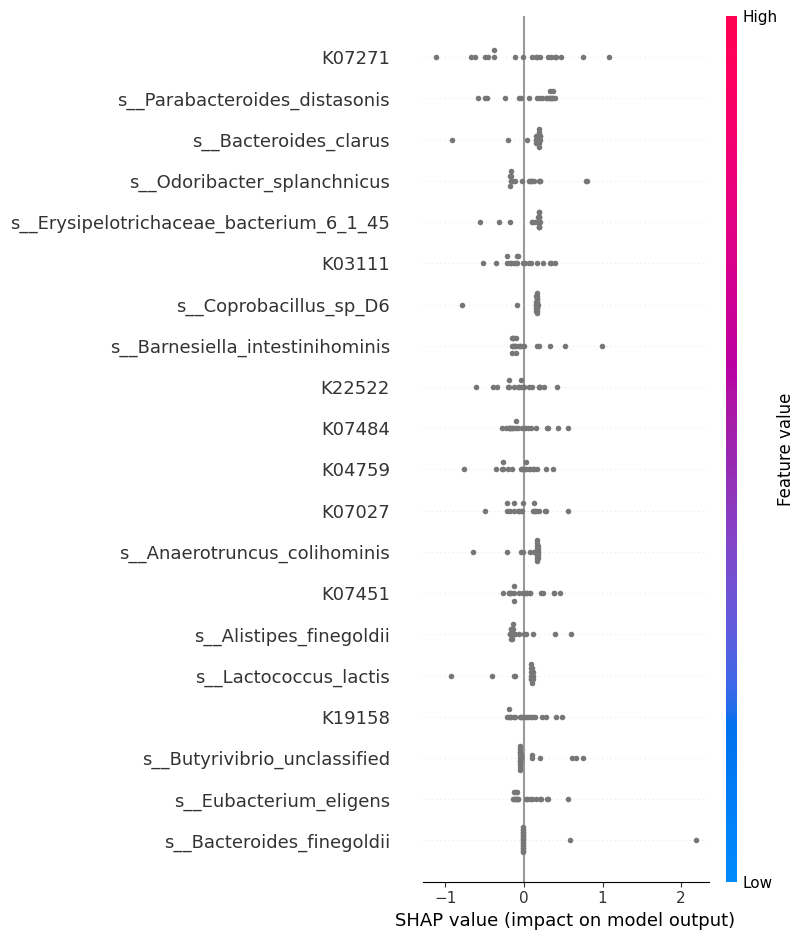

In [12]:
shap.summary_plot(shap_values.squeeze(), x_test, feature_names=feat_names, rng=np.random.default_rng(), show=False,)

In [13]:
plt.gcf()  # 获取当前图形

# 调整布局，确保图形的各个部分不会重叠
plt.tight_layout()

# 保存图像
plt.savefig("./a.png", dpi=300)  # 保存为 PNG 文件，300 DPI 确保图像高质量

# 关闭图形，释放资源
plt.close()

In [1]:
from explainable import explain

In [3]:
for seed in [392, 412, 432, 452, 472]:
    explain("LC", "MTMFTransformer", "ko,species", seed)

['ko', 'species']
['HD-1', 'HD-10', 'HD-11', 'HD-12', 'HD-13']
['HD-1', 'HD-10', 'HD-11', 'HD-12', 'HD-13']
Load dataset from /hdd/wmh/MSFT-Transfromer/Data/LC/ko_abundance.csv
Load dataset from /hdd/wmh/MSFT-Transfromer/Data/LC/species_abundance.csv
Counter({1: 94, 0: 91}) Counter({1: 24, 0: 23})


RuntimeError: CUDA out of memory. Tried to allocate 11.08 GiB (GPU 0; 47.73 GiB total capacity; 23.33 GiB already allocated; 7.66 GiB free; 28.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF